In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
dir = "./DL-Project/"

def load(i):
    data = np.load(dir+f'data{i}.npy')
    label = np.load(dir+f'lab{i}.npy')

data0,lab0 = load(0)
data1,lab1  = load(1)
data2,lab2  = load(2)

data = np.concatenate([data0, data1, data2], axis=0)
labels = np.concatenate([lab0, lab1, lab2], axis=0)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)


In [ ]:
class Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

train_dataset = Dataset(train_data, train_labels, transform=transform)
val_dataset = Dataset(val_data, val_labels, transform=transform)
test_dataset = Dataset(test_data, test_labeansform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 37)  
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  


criterion = nn.CrossEntropyLoss()
layerwise_params = [
    {"params": model.module.conv1.parameters(), "lr": 1e-5}, 
    {"params": model.module.layer1.parameters(), "lr": 1e-4},  
    {"params": model.module.layer2.parameters(), "lr": 3e-4},
    {"params": model.module.layer3.parameters(), "lr": 3e-4},
    {"params": model.module.layer4.parameters(), "lr": 1e-3},  
    {"params": model.module.fc.parameters(), "lr": 3e-3},  
]

optimizer = optim.Adam(layerwise_params, weight_decay=1e-4)




In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    best_model = None
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_pbar = tqdm(train_loader, leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = 100 * correct_train / total_train
        train_loss = train_loss / len(train_loader.dataset)
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()
            torch.save(model, 'resnet_step.pth')

    
    model.load_state_dict(best_model)
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
    return model

In [ ]:

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
model=train_model(model,train_loader,val_loader,criterion,optimizer)
evaluate_model(model, test_loader)



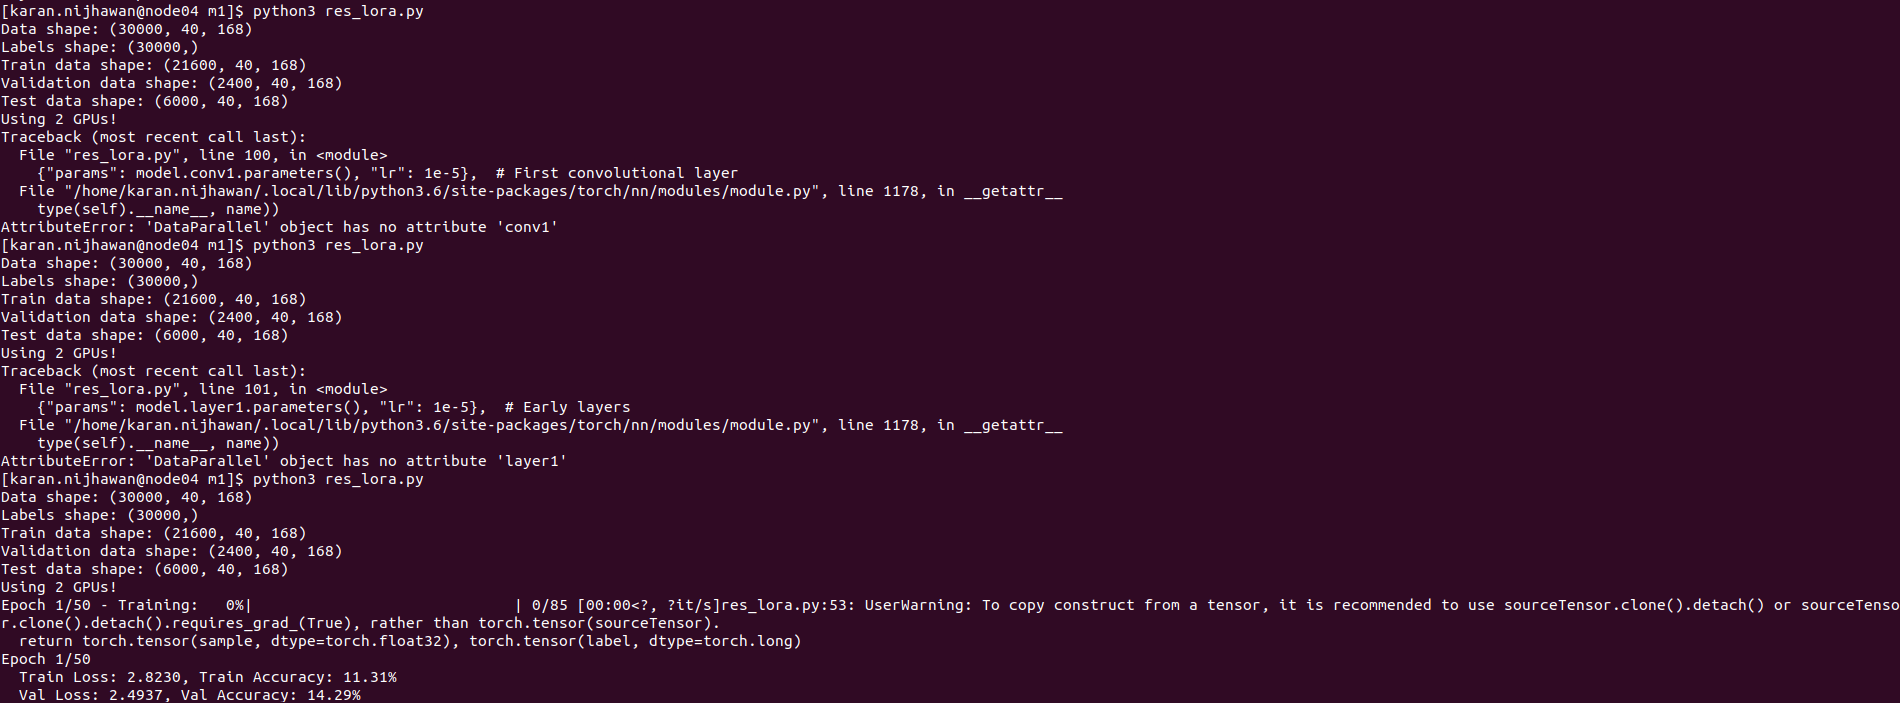

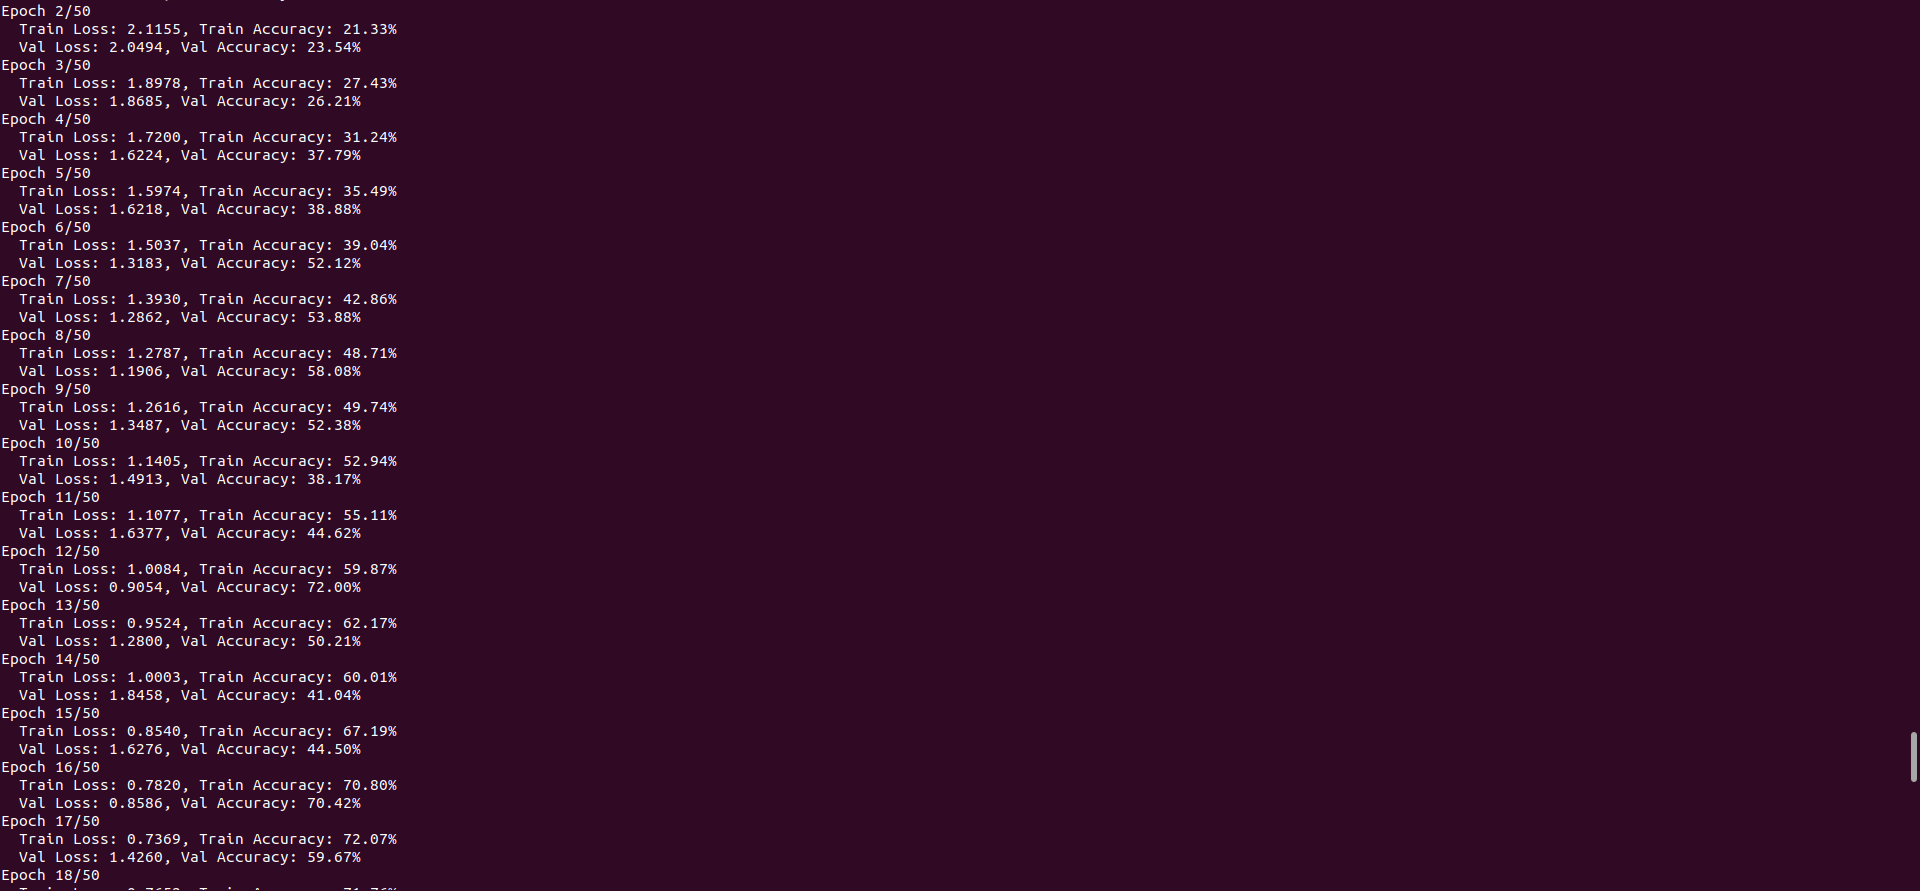

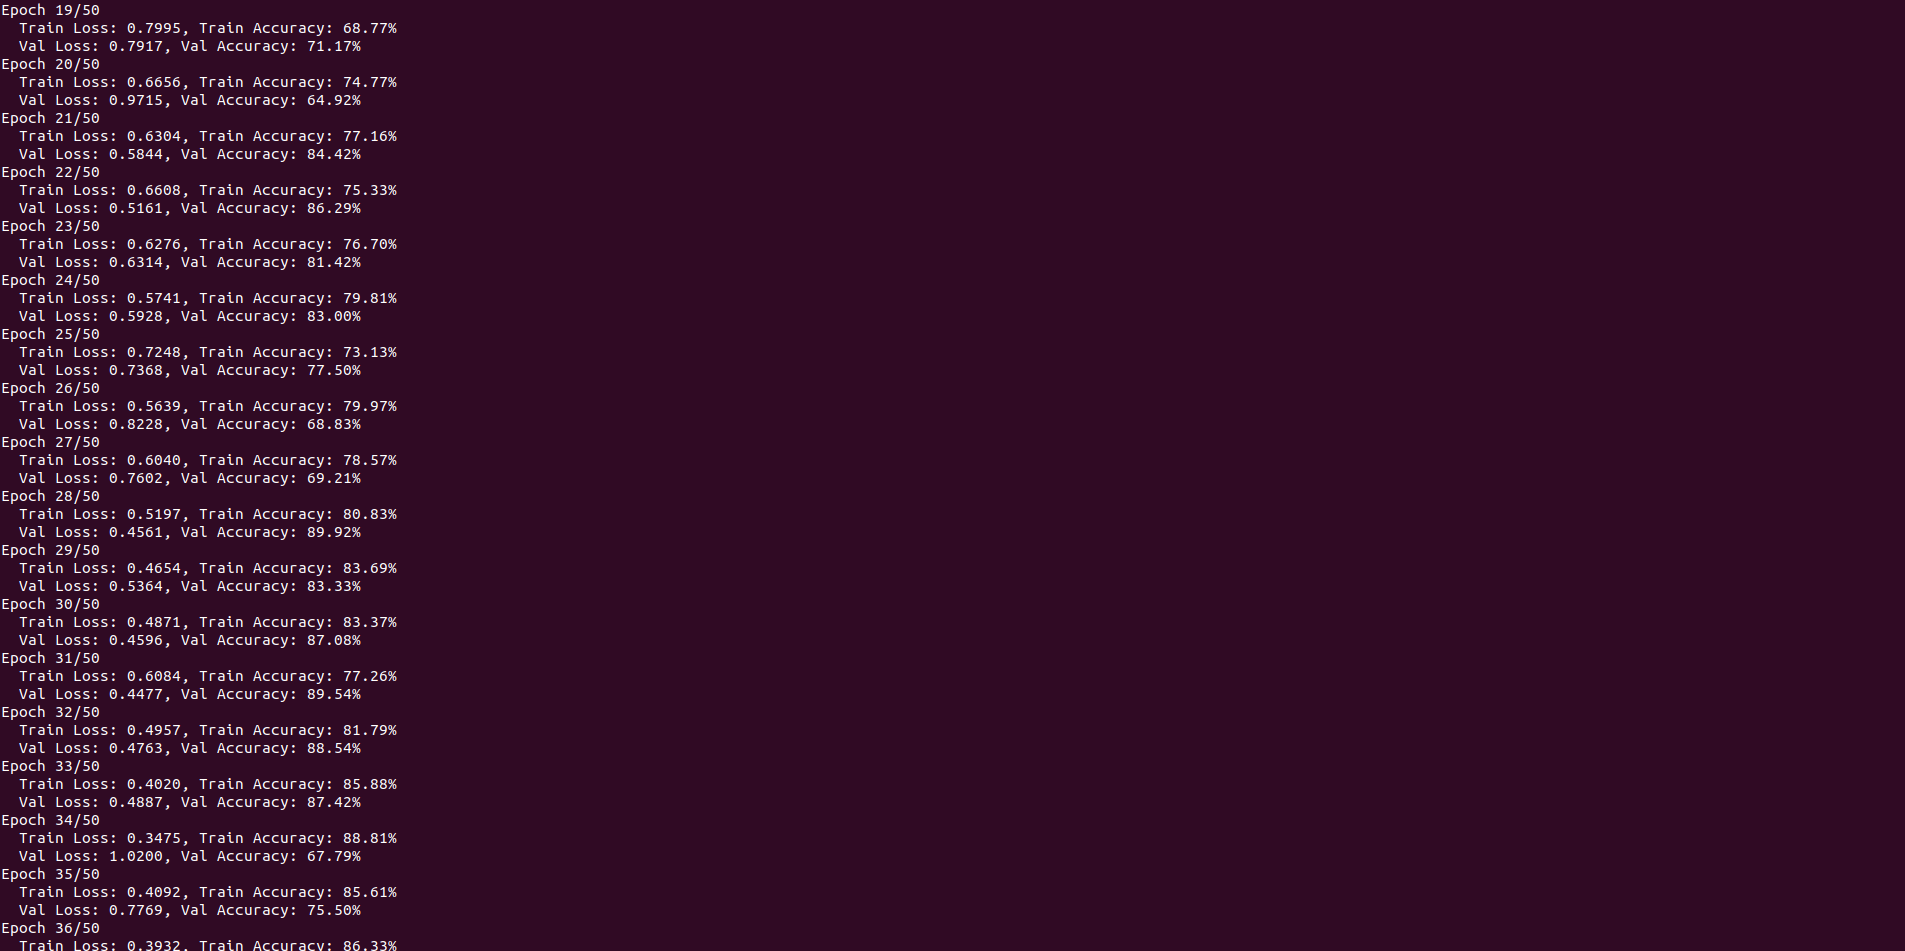

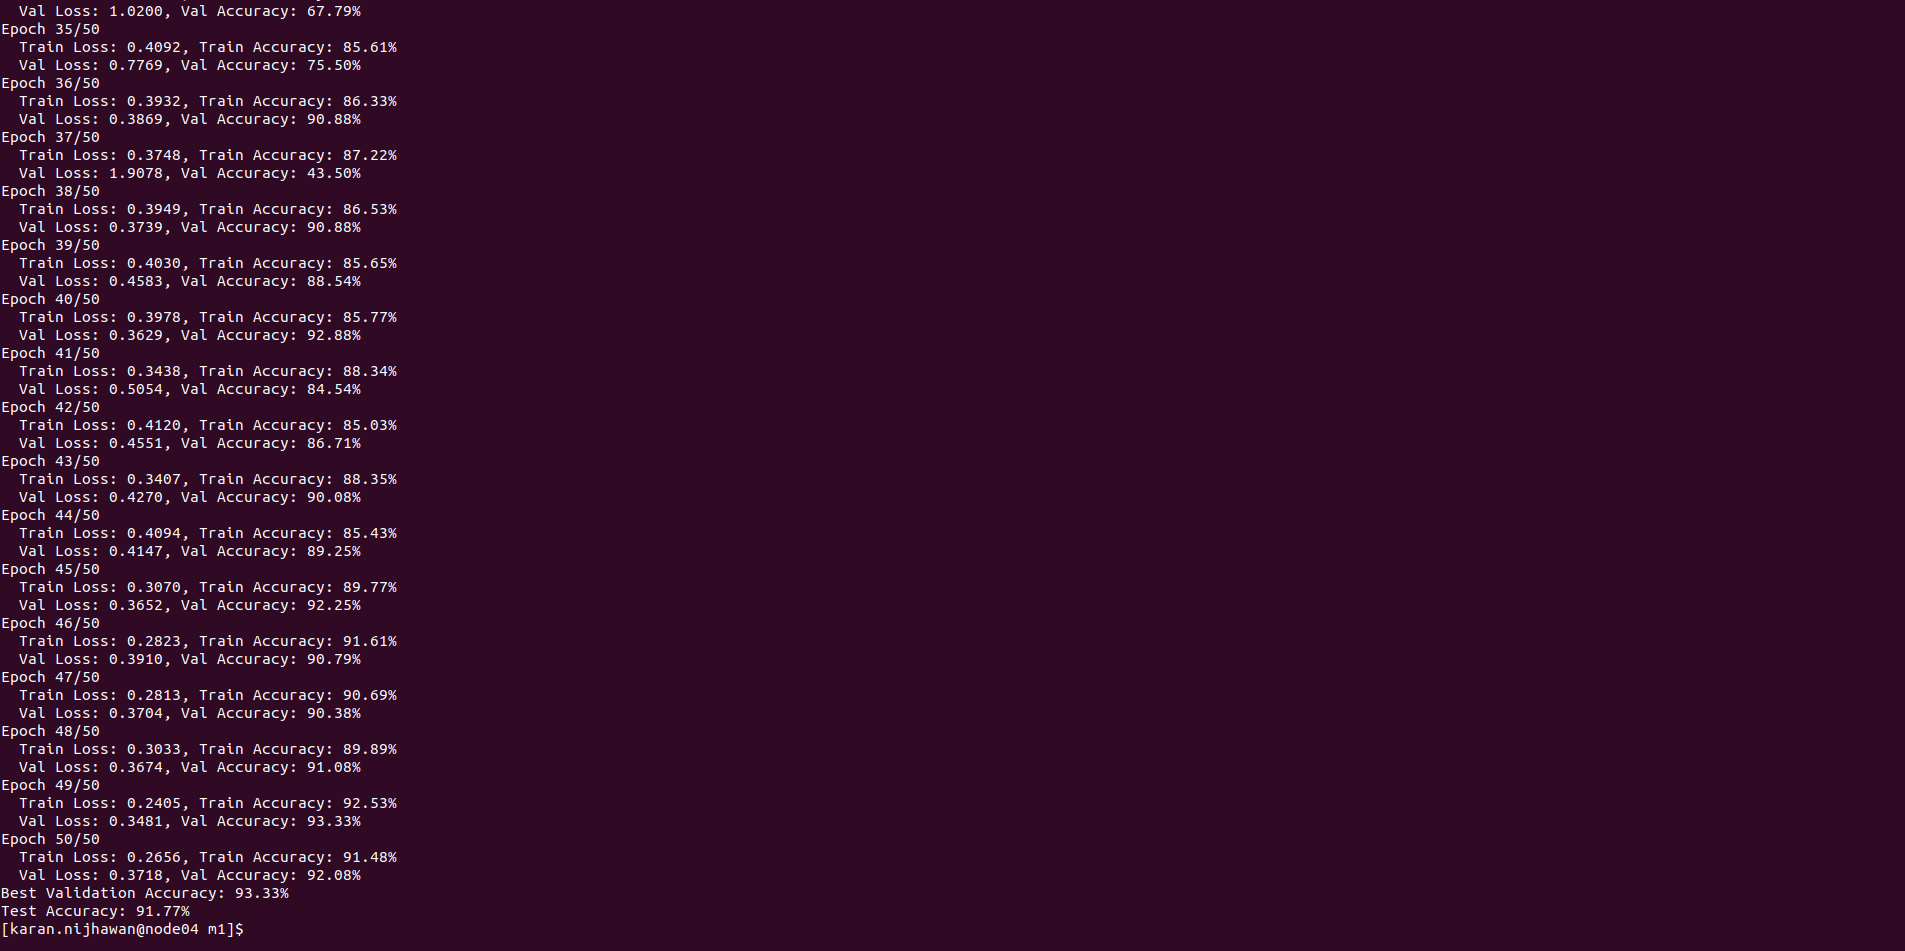

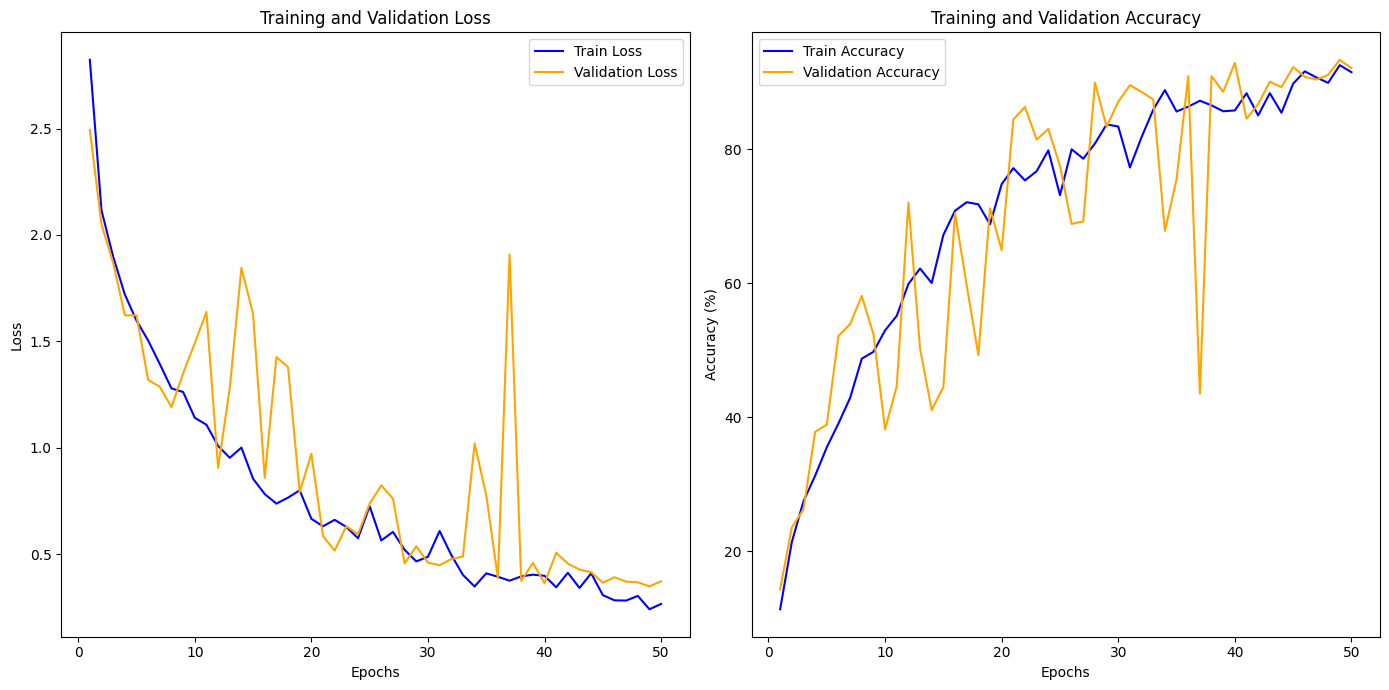

In [1]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 51))
train_loss = [2.8230, 2.1155, 1.8978, 1.7200, 1.5974, 1.5037, 1.3930, 1.2787, 1.2616, 1.1405,
              1.1077, 1.0084, 0.9524, 1.0003, 0.8540, 0.7820, 0.7369, 0.7652, 0.7995, 0.6656,
              0.6304, 0.6608, 0.6276, 0.5741, 0.7248, 0.5639, 0.6040, 0.5197, 0.4654, 0.4871,
              0.6084, 0.4957, 0.4020, 0.3475, 0.4092, 0.3932, 0.3748, 0.3949, 0.4030, 0.3978,
              0.3438, 0.4120, 0.3407, 0.4094, 0.3070, 0.2823, 0.2813, 0.3033, 0.2405, 0.2656]
val_loss = [2.4937, 2.0494, 1.8685, 1.6224, 1.6218, 1.3183, 1.2862, 1.1906, 1.3487, 1.4913,
            1.6377, 0.9054, 1.2800, 1.8458, 1.6276, 0.8586, 1.4260, 1.3787, 0.7917, 0.9715,
            0.5844, 0.5161, 0.6314, 0.5928, 0.7368, 0.8228, 0.7602, 0.4561, 0.5364, 0.4596,
            0.4477, 0.4763, 0.4887, 1.0200, 0.7769, 0.3869, 1.9078, 0.3739, 0.4583, 0.3629,
            0.5054, 0.4551, 0.4270, 0.4147, 0.3652, 0.3910, 0.3704, 0.3674, 0.3481, 0.3718]
train_acc = [11.31, 21.33, 27.43, 31.24, 35.49, 39.04, 42.86, 48.71, 49.74, 52.94,
             55.11, 59.87, 62.17, 60.01, 67.19, 70.80, 72.07, 71.76, 68.77, 74.77,
             77.16, 75.33, 76.70, 79.81, 73.13, 79.97, 78.57, 80.83, 83.69, 83.37,
             77.26, 81.79, 85.88, 88.81, 85.61, 86.33, 87.22, 86.53, 85.65, 85.77,
             88.34, 85.03, 88.35, 85.43, 89.77, 91.61, 90.69, 89.89, 92.53, 91.48]
val_acc = [14.29, 23.54, 26.21, 37.79, 38.88, 52.12, 53.88, 58.08, 52.38, 38.17,
           44.62, 72.00, 50.21, 41.04, 44.50, 70.42, 59.67, 49.25, 71.17, 64.92,
           84.42, 86.29, 81.42, 83.00, 77.50, 68.83, 69.21, 89.92, 83.33, 87.08,
           89.54, 88.54, 87.42, 67.79, 75.50, 90.88, 43.50, 90.88, 88.54, 92.88,
           84.54, 86.71, 90.08, 89.25, 92.25, 90.79, 90.38, 91.08, 93.33, 92.08]

# Plotting the results
plt.figure(figsize=(14, 7))

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
